In [29]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
import ast
import re
import shapely
from dateutil import parser

## Documentation

### Methodology
#### 1. Create and initialize an output dataframe to be filled later: 
A dataframe with the schema [minute_local | hex_id | vehicle_count]. The `minute_local` column values span the date range covered by the MDS data and the *time of day* range defined as an arg by the user.

#### 2. Process MDS trips of each vehicle separately:
##### 2.1. Invert the trip's occupied time into the idle periods:
And idle period has the following schema: [vehicle_id, start_time, end_time, location]
The idle period starts at the `end_time` of a trip (i) and ends at the `start_time` of the following trip (i+1). Its location is the last point along the route of trip (i).
The assumption is that whenever a trip is idle, it is considered rentable.
##### 2.2. Process idle time instances:
A trip may end on one day, and the following trip starts one or more days later. We cannot be sure whether the vehicle was actually available for rent during that time or maybe taken out of service for maintenance.
This processing step replace idle times that span multiple days with two instances, as the following example illustrates:

Given an idle period 
| vehicle_id | start_time          | end_time            | location |
|------------|---------------------|---------------------|----------|
| V_1        | 2021-10-22 19:00:00 | 2021-10-25 08:00:00 | L_1      |
                                |
                                V
It is transformed to two rows:
| vehicle_id | start_time          | end_time            | location |
|------------|---------------------|---------------------|----------|
| V_1        | 2021-10-22 19:00:00 | 2021-10-22 23:59:00 | L_1      |
| V_1        | 2021-10-25 00:00:00 | 2021-10-25 08:00:00 | L_1      |

##### 2.3. Spatially join idle period location with zones
##### 2.4. Convert idle period to output format:
Given:
- idle period matched spatially with a zone Z_1
- User selects time of day window 07:00 -> 09:00

| vehicle_id | start_time          | end_time            | location | zone_id |
|------------|---------------------|---------------------|----------|---------|
| V_1        | 2021-10-22 06:00:00 | 2021-10-22 07:20:00 | L_1      | Z_1     |

                                |
                                V
It's transformed into:
| minute_local        | zone_id | vehicle_id |
|---------------------|---------|------------|
| 2021-10-22 07:00:00 | Z_1     | V_1        |
| 2021-10-22 07:01:00 | Z_1     | V_1        |
| ...                 |         |            |
| 2021-10-22 07:20:00 | Z_1     | V_1        |

#### 3. Aggregate output per zone per minute:

Get the count of vehicles per zone per minute.
| minute_local        | zone_id | rentable_scooter_count |
|---------------------|---------|------------------------|
| 2021-10-22 07:00:00 | Z_1     | 2                      |

## Arguments

In [30]:
mds_filepaths = ['32_wri_numo-main-data_raw-San Francisco-GBFS/data_raw/San Francisco/GBFS/SF MDS/sf_mds1.csv', \
                    '32_wri_numo-main-data_raw-San Francisco-GBFS/data_raw/San Francisco/GBFS/SF MDS/sf_mds2.csv', \
                    '32_wri_numo-main-data_raw-San Francisco-GBFS/data_raw/San Francisco/GBFS/SF MDS/sf_mds3.csv', \
                    '32_wri_numo-main-data_raw-San Francisco-GBFS/data_raw/San Francisco/GBFS/SF MDS/sf_mds4.csv', \
                    ]
zones_filepath = '32_wri_numo-main-data_raw-San Francisco-GBFS/zones_w_micromobility_providers.geojson'
zone_id_col = 'cell_id'
output_file_path = "./output/SF_MDS_cleaned_hexgrid_scooter_counts.csv"

# mds_filepaths = ['bird_Minneapolis MDS-20220523T190657Z-001/Minneapolis MDS/minneapolis_mds1.csv', \
#                     'bird_Minneapolis MDS-20220523T190657Z-001/Minneapolis MDS/minneapolis_mds2 .csv', \
#                     'bird_Minneapolis MDS-20220523T190657Z-001/Minneapolis MDS/minneapolis_mds3.csv', \
#                     'bird_Minneapolis MDS-20220523T190657Z-001/Minneapolis MDS/minneapolis_mds4.csv', \
#                     ]
# zones_filepath = 'bird_Minneapolis MDS-20220523T190657Z-001/zones_w_micromobility_providers.geojson'
# zone_id_col = 'cell_id'
# output_file_path = "./output/Minneapolis_MDS_cleaned_hexgrid_scooter_counts.csv"

timeofday_start_24hr = "07:00"
timeofday_end_24hr = "09:00"

## Cleaning Script

In [72]:
mds_df_arr = [pd.read_csv(path) for path in mds_filepaths]
mds = pd.concat(mds_df_arr)

In [73]:
# Check duplicate rows
mds.duplicated().sum()

409

In [74]:
# Drop duplicates
mds = mds.drop_duplicates('trip_id')

In [34]:
zones = gpd.read_file(zones_filepath)

In [35]:
date_start = parser.parse(mds.start_time.min()).date()
date_end = parser.parse(mds.end_time.max()).date()

# Create empty dataframe
zones_ids = zones[zone_id_col].unique()
time_start = parser.parse(timeofday_start_24hr).time()
time_end = parser.parse(timeofday_end_24hr).time()
date_delta = (date_end - date_start).days
minute_delta =  int((parser.parse(timeofday_end_24hr) - parser.parse(timeofday_start_24hr)).total_seconds() // 60)



In [36]:
arr = []
for i in range(date_delta):
    curr_date = date_start + datetime.timedelta(days=i)
    curr_datetime = datetime.datetime(curr_date.year, curr_date.month, curr_date.day, time_start.hour, time_start.minute)
    for j in range(minute_delta):
        for zone_id in zones_ids:
            arr.append([curr_datetime + datetime.timedelta(minutes=j), zone_id])
output_df = pd.DataFrame(arr, columns=['minute_local', 'zone_id'])


In [37]:
vehicle_ids = list(mds['vehicle_id'].unique())

In [38]:
len(vehicle_ids)

1092

In [39]:
from multiprocessing import Pool

def convert_trip_instance_to_idle_periods(mds_df):
    sorted_mds_df = mds_df.sort_values('start_time')
    idle_time = []
    for i in range(len(sorted_mds_df)-1):
        vehicle_id = sorted_mds_df.iloc[i].vehicle_id
        start_time = sorted_mds_df.iloc[i].end_time
        end_time = sorted_mds_df.iloc[i+1].start_time

        # Assign the last point in the route as the idle time location
        location_wkt = re.findall(r"(POINT\([\d\-\.]* [\d\.\-]*\))", sorted_mds_df.iloc[i]['route'])[-1]
        # TODO: Consider adding error handling/reporting here
        location_point = shapely.wkt.loads(location_wkt)
        
        idle_time.append([vehicle_id, start_time, end_time, location_point])

    return gpd.GeoDataFrame(pd.DataFrame(idle_time, columns=['vehicle_id', 'start_time', 'end_time', 'location']), geometry='location', crs='epsg:4326')



def process_idle_instances(idle_instances_df):
    arr = []
    def process_instance(row):
        start_date = parser.parse(row.start_time).date()
        end_date = parser.parse(row.end_time).date()
        if start_date == end_date:
            arr.append(row.tolist())
        elif end_date > start_date:
            # split the idle time into two instances
            # 1: start_time -> start_date@23:59
            arr.append([row.vehicle_id, str(row.start_time), str(datetime.datetime.combine(start_date, datetime.time(23,59))), row.location])
            # 2: end_date@00:00 -> end_time
            arr.append([row.vehicle_id, str(datetime.datetime.combine(end_date, datetime.time(0,0))), str(row.end_time), row.location])
        else:
            pass

    idle_instances_df.apply(process_instance, axis=1)
    return gpd.GeoDataFrame(pd.DataFrame(arr, columns=['vehicle_id', 'start_time', 'end_time', 'location']), geometry='location', crs='epsg:4326')



def expand_idle_instances_to_row_per_minute(timeofday_start_24hr, timeofday_end_24hr, idle_instances_df):
    time_start = parser.parse(timeofday_start_24hr).time()
    time_end = parser.parse(timeofday_end_24hr).time()

    arr = []
    for i, row in idle_instances_df.iterrows():
        start_datetime = parser.parse(row.start_time).replace(second=0, microsecond=0, tzinfo=None)
        end_datetime = parser.parse(row.end_time).replace(second=0, microsecond=0, tzinfo=None)
        time_delta = end_datetime - start_datetime
        time_delta_minutes = int(time_delta.total_seconds() // 60)

        for i in range(time_delta_minutes):
            shifted_datetime = start_datetime + datetime.timedelta(minutes=i)
            
            if (shifted_datetime.time() > time_start) and (shifted_datetime.time() < time_end):
                arr.append([shifted_datetime, row.zone_id, row.location, row.vehicle_id])
    
    return pd.DataFrame(arr, columns=['minute_local', 'zone_id', 'geometry', 'vehicle_id']) \
                            .drop('geometry', axis=1)


def f(single_vehicle_mds_df):
    idle_instances_gdf = convert_trip_instance_to_idle_periods(single_vehicle_mds_df)
    processed_idle_instances_gdf = process_idle_instances(idle_instances_gdf)
    idle_instances_with_zones = processed_idle_instances_gdf.sjoin(zones[['zone_id', 'geometry']])
    row_per_idle_minute = expand_idle_instances_to_row_per_minute(timeofday_start_24hr, timeofday_end_24hr, idle_instances_with_zones)
    
    return {'per_minute': row_per_idle_minute, 'idle_periods': processed_idle_instances_gdf}


with Pool(5) as p:
    all_vehicles = p.map(f, [mds[mds['vehicle_id']== v_id] for v_id in vehicle_ids])


## Output Inspection

In [40]:
per_minute_df = pd.concat([result['per_minute'] for result in all_vehicles]).groupby(['minute_local', 'zone_id'])   \
                            .count()    \
                            .rename(columns={'vehicle_id':'rentable_scooter_count'})   

joined = output_df.merge(per_minute_df, how='left', on=['minute_local', 'zone_id'])
joined['rentable_scooter_count'] = joined['rentable_scooter_count'].fillna(0).astype(np.int64)
joined.rentable_scooter_count.value_counts()

0     14109478
1       303450
2        95319
3        39865
4        23086
5        13685
6        10591
7         6783
9         4046
8         4046
10        2499
12        1785
13        1547
11        1428
16         952
14         952
15         833
19         595
21         476
18         476
22         238
26         238
20         238
24         238
27         119
28         119
23         119
17         119
Name: rentable_scooter_count, dtype: int64

<AxesSubplot:>

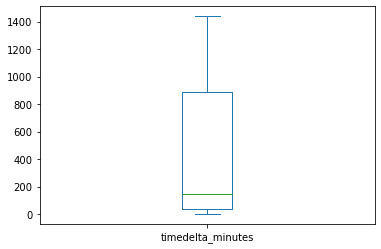

In [41]:
## Visualizing distribution of the length of idle periods
idle_periods = [result['idle_periods'] for result in all_vehicles]
all_idle_times_df = pd.concat(idle_periods)
all_idle_times_df['timedelta_minutes'] = all_idle_times_df.apply(lambda row: (parser.parse(row.end_time).replace(second=0, microsecond=0, tzinfo=None) - parser.parse(row.start_time).replace(second=0, microsecond=0, tzinfo=None)).total_seconds() // 60, axis=1)
all_idle_times_df.timedelta_minutes.plot.box()

<AxesSubplot:ylabel='Frequency'>

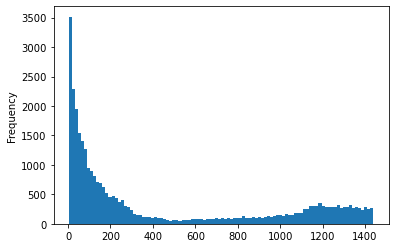

In [42]:
all_idle_times_df[all_idle_times_df['timedelta_minutes']>3].timedelta_minutes.plot.hist(bins=100)

In [65]:
(joined.rentable_scooter_count>10).sum()

10472

In [76]:
mds.start_time.min()

'2021-07-31 22:47:40.712000+00:00'

<AxesSubplot:>

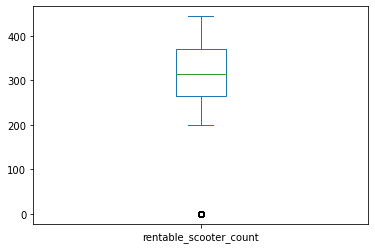

In [67]:
joined.groupby('minute_local').sum().rentable_scooter_count.plot.box()

## Write Output To Disk

In [43]:
# Write output dataframe
joined.to_csv(output_file_path)